In [1]:
# import stuff
import os
cwd = os.getcwd()
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import json
import re
# import json
#from textwrap import wrap 
#from collections import Counter
#from nltk.corpus import stopwords
#stopw=set(stopwords.words('english'))
%matplotlib inline 
# display matplotlib plots in jupyter
# plt.ioff() 
# stops graphs from over writing eachother
import glob

# Get palette with right number of steps

In [17]:
sns.palettes.color_palette('Reds', 11).as_hex()

['#fee7dc',
 '#fdd4c2',
 '#fcbba1',
 '#fca082',
 '#fc8565',
 '#fb694a',
 '#f34a36',
 '#e32f27',
 '#ca181d',
 '#b11218',
 '#900a12']

# New York Census, race data

In [2]:
files = ['Data/NY_Census_Race_Data__R_Manipulated_With_Poverty_Eliminated_V2.geojson']
files

['Data/NY_Census_Race_Data__R_Manipulated_With_Poverty_Eliminated_V2.geojson']

In [44]:
with open('Data/reduced_census.geojson') as f:
    data = json.load(f)

In [45]:
data['features'][100]['properties']

{'% of Families Below Poverty Level': 4.0,
 'ALAND10': '438636',
 'AWATER10': '0',
 'American_Indian_and_Alaska_Natives_Perc_P003004': '0.3',
 'Asian_Alone_Perc_P003005': '16.5',
 'Black_African_Americans_Alone_Perc_P003003': '2.9',
 'CBSA': '35620',
 'COUNTY': ' 85',
 'COUNTYFP10': '085',
 'CSA': '408',
 'FUNCSTAT10': 'S',
 'GEOID': '36085027706',
 'GEOID10': '36085027706',
 'HU100': ' 1188',
 'HU100.2000': ' 1180',
 'INTPTLAT10': '+40.5909369',
 'INTPTLON10': '-074.1619016',
 'MTFCC10': 'G5020',
 'Median Household Income': '68750',
 'NAME': 'Census Tract 277.06',
 'NAME10': '277.06',
 'NAMELSAD10': 'Census Tract 277.06',
 'Native_Hawaiian_and_Other_Pacific_Islanders_Perc_P003006': '0.0',
 'Other_Race_Perc_P003007': '3.8',
 'POP100': ' 2950',
 'POP100.2000': ' 3142',
 'Perc_POC_P003009': 25.700000000000003,
 'Race_Total_P003001': ' 2950',
 'STATE': '36',
 'STATEFP10': '36',
 'SUMLEV': '140',
 'TRACTCE10': '027706',
 'Two_Or_More_Perc_P003008': '2.2',
 'White_Alone_Perc_P003002': '74.3

In [46]:
NYC_COUNTIES = {'005': 'Bronx','047': 'Brooklyn','061': 'Manhattan','081': 'Queens', '085': 'Staten Island'}
def try_to_cast(x):
    try:
        x = float(x)
    except ValueError:
        if x == '#DIV/0!':
            x = 0
    return x

def load_json_to_df(filename, identifying_func):
    with open(filename) as f:
        data = json.load(f)['features']
    df = []
    for d in data:
        row = d['properties']
        if row['COUNTYFP10'] not in NYC_COUNTIES.keys():
            continue
        row_data = dict((k, try_to_cast(v)) for (k, v) in row.items() if identifying_func(k))
        row_data['County'] = NYC_COUNTIES[row['COUNTYFP10']]
        census_tract = re.search('Census Tract ([0-9.]+)', row['NAME']).groups()[0]
        df.append(pd.DataFrame(row_data, index=[census_tract]))
    df = pd.concat(df).reset_index()
    df = df.rename(columns={'index': 'Census_tract'})
    return df

def edit_and_save_json(filename, output_file):
    with open(filename) as f:
        data = json.load(f)
    idx = []
    for i, d in enumerate(data['features']):
        try:
            if try_to_cast(d['properties']['Race_Total_P003001']) > 0:
                d['properties']['Perc_POC_P003009'] = 100 - try_to_cast(d['properties']['White_Alone_Perc_P003002'])
            else:
                d['properties']['Perc_POC_P003009'] = -10
        except TypeError:
            d['properties']['Perc_POC_P003009'] = -20
        d['properties']['% of Families Below Poverty Level'] = try_to_cast(d['properties']['% of Families Below Poverty Level'])
        d['properties']['Median Household Income'] = try_to_cast(d['properties']['Median Household Income'])
        if d['properties']['COUNTYFP10'] in NYC_COUNTIES.keys():
            idx.append(i)
    data_to_save = {'type': data['type'], 'crs': data['crs']}
    data_to_save['features'] = [data['features'][i] for i in idx]
    with open(output_file, 'w') as f:
        json.dump(data_to_save, f)

In [25]:
identifying_func = lambda x: 'P003' in x
df = load_json_to_df(files[0], lambda x: 'Median' in x)

In [35]:
np.percentile(df['Median Household Income'].values, q=[10, 25, 50, 75, 90, 99])

array([ 22167.  ,  34672.5 ,  49890.5 ,  66832.  ,  85947.  , 132039.03])

In [42]:
df['Median Household Income'].dtype

dtype('float64')

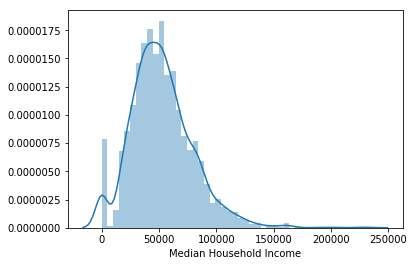

In [36]:
sns.distplot(df['Median Household Income'])

In [5]:
plot_df = pd.melt(df, id_vars=['County', 'Census_tract'])

For whatever reason, there's one census tract in the Bronx that has a really large population, the only one with more than 20,000. If you look at the [interactive census map](https://www.census.gov/2010census/popmap/), they break that block up in multiple smaller ones, but for some reason this data set does not (it's way up at the north of the Bronx, census tract 462.01).

C:\Users\Maija\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


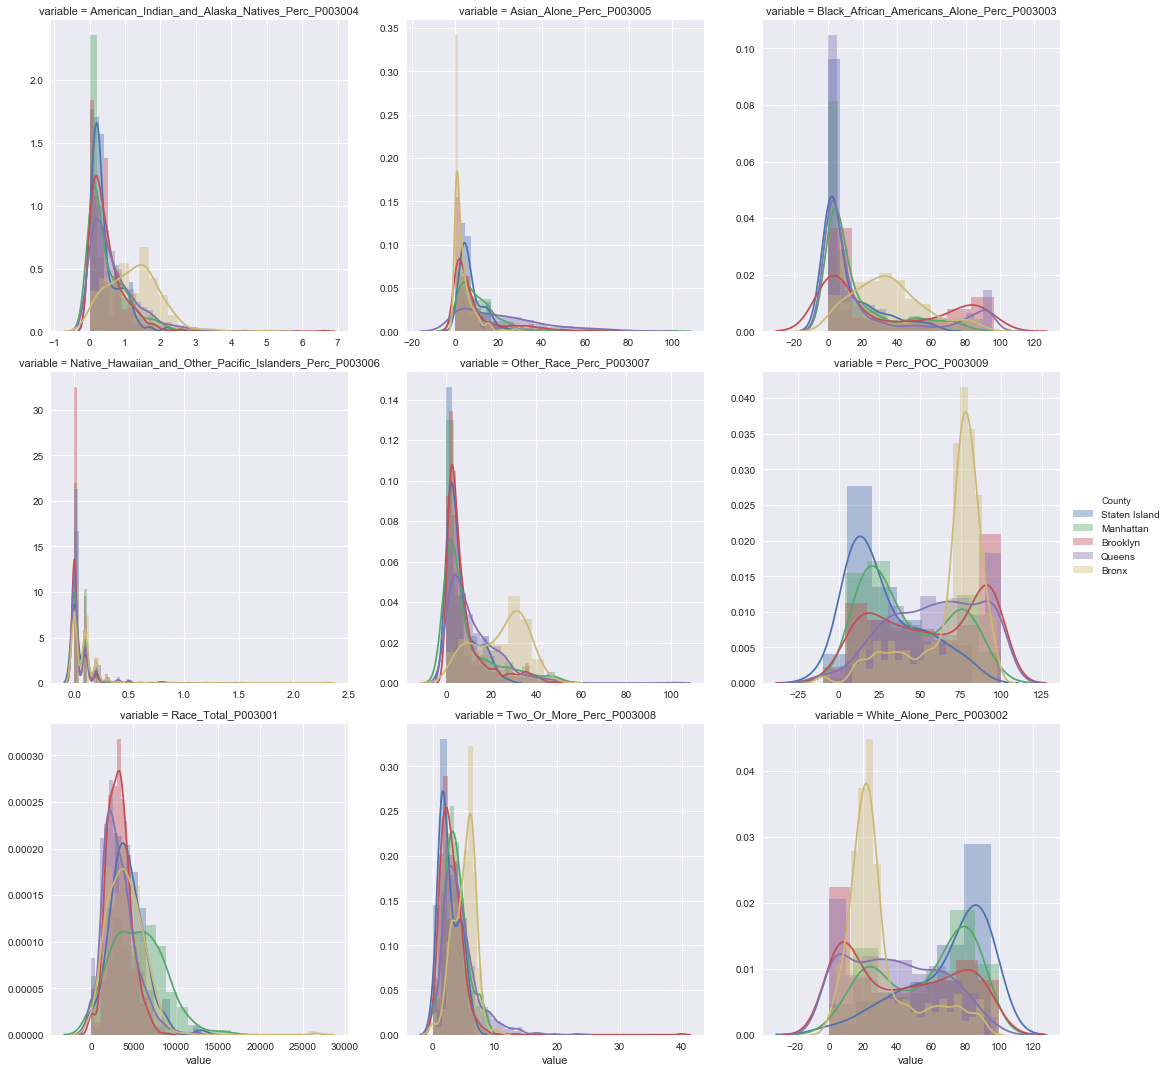

In [9]:
g = sns.FacetGrid(plot_df, col='variable', hue='County', col_wrap=3, size=5, sharex=False, sharey=False)
g.map(sns.distplot, 'value')
g.add_legend()

In [47]:
edit_and_save_json(files[0], 'Data/reduced_census.geojson')

# New York City zoning data

In [8]:
with open('Data/nyzd.geojson') as f:
    data = json.load(f)

In [9]:
data['features'][5]['properties']

{'@id': 'http://nyc.pediacities.com/Resource/Zone/R3-1',
 'ZONEDIST': 'R3-1',
 'human_readable_zone': 'Residential'}

In [4]:
# from https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/zoningtaxlotdatabase_datadictionary.pdf?r=1217
def zoning_definitions(x):
    if x.startswith('R'):
        return 'Residential'
    elif x.startswith('C'):
        return 'Commercial'
    elif x == 'BPC':
        return 'Battery Park City'
    elif x == 'PARK':
        return 'New York City Parks'
    elif x == 'PARKNYS':
        return 'New York State Parks'
    elif x == 'PARKUS':
        return 'United States Parks'
    elif x == 'ZNA':
        return 'Zoning not applicable'
    elif x == 'ZR 11-151':
        return 'Special zone in Queens'
    elif '/R' in x:
        return 'Mixed manufacturing and residential'
    elif x.startswith('M'):
        return 'Manufacturing'
    else:
        return x

def try_to_cast(x):
    try:
        x = float(x)
    except ValueError:
        if x == '#DIV/0!':
            x = 0
    return x

def load_json_to_df(filename):
    with open(filename) as f:
        data = json.load(f)['features']
    df = []
    for c, d in enumerate(data):
        row = d['properties']
        df.append(pd.DataFrame({'zone_designation': row['ZONEDIST']}, index=[c]))
    df = pd.concat(df).reset_index()
    df = df.rename(columns={'index': 'Zone number'})
    return df

def edit_and_save_json(filename):
    with open(filename) as f:
        data = json.load(f)
    for d in data['features']:
        d['properties']['human_readable_zone'] = zoning_definitions(d['properties']['ZONEDIST'])
    with open(filename, 'w') as f:
        json.dump(data, f)

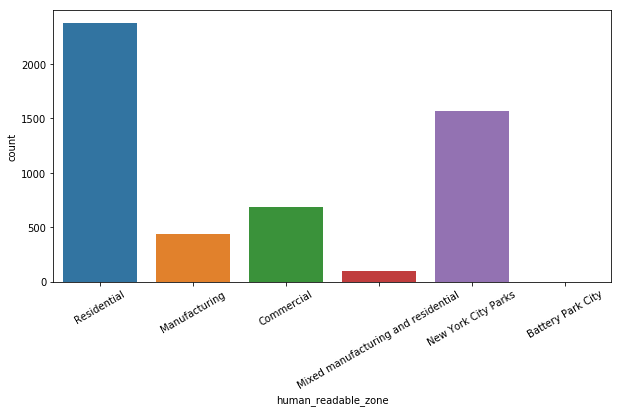

In [14]:
#compare to the brox brooklyn only
df = load_json_to_df('Data/nyzd.geojson')
df['human_readable_zone'] = df.zone_designation.apply(zoning_definitions)
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(x='human_readable_zone', data=df)
_=plt.xticks(rotation=30)

In [7]:
edit_and_save_json('Data/nyzd.geojson')


# Percent uninsured by neighborhood

In [48]:
with open('Data/NeighborhoodUninsured.geojson') as f:
    data = json.load(f)

In [49]:
data['features'][5]['properties']

{'BOROUGH': 'Bronx',
 'OBJECTID': 6,
 'SHAPE_Area': 106897846.11,
 'SHAPE_Leng': 66676.0891,
 'UHFCODE': 105,
 'UHF_NEIGH': 'Crotona - Tremont',
 'Uninsured_Perc': 25}

In [50]:
def try_to_cast(x):
    try:
        x = float(x)
    except ValueError:
        if x == '#DIV/0!':
            x = 0
    return x

def load_json_to_df(filename):
    with open(filename) as f:
        data = json.load(f)['features']
    df = []
    for d in data:
        row = d['properties']
        df.append(pd.DataFrame({'uninsured': row['Uninsured_Perc']}, index=[row['OBJECTID']]))
    df = pd.concat(df).reset_index()
    df = df.rename(columns={'index': 'Neighborhood number'})
    return df

def edit_and_save_json(filename):
    with open(filename) as f:
        data = json.load(f)
    for d in data['features']:
        d['properties']['Human_Readable_Zone'] = zoning_definitions(d['properties']['ZONEDIST'])
    with open(filename, 'w') as f:
        json.dump(data, f)

In [51]:
df = load_json_to_df('Data/NeighborhoodUninsured.geojson')

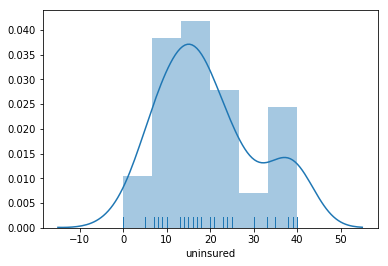

In [54]:
sns.distplot(df.uninsured, rug=True )